<a href="https://colab.research.google.com/github/gregorio-saporito/hate-speech-detection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Mining and Sentiment Analysis: Hate Speech Detection
Gregorio Luigi Saporito - DSE (2020-2021)

### Libraries

In [1]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
import nltk
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import xgboost as xgb
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Upload the data to session storage
Upload here below the __labeled_data.csv__ file. The labels correspond to
- 0: hate speech
- 1: offensive language
- 2: neither

In [2]:
# upload here the data
uploaded = files.upload()

Saving labeled_data.csv to labeled_data.csv


In [3]:
# read the csv file and rename the columns
fields = ['Unnamed: 0', 'class', 'tweet']
raw = pd.read_csv('labeled_data.csv', usecols=fields)\
  .rename(columns={"Unnamed: 0": "id", "class": "label"})

### Inspect the data

In [4]:
# snapshot of the first rows
raw.head()

,id,label,tweet
0,0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
# size of the dataset
raw.shape

(24783, 3)

In [6]:
# inspect the presence of missing values
print(
    'Check for null values\n' +
    str(raw.isnull().sum()) + '\n'
    'Check for na values\n' +
    str(raw.isna().sum())
)

Check for null values
id       0
label    0
tweet    0
dtype: int64
Check for na values
id       0
label    0
tweet    0
dtype: int64


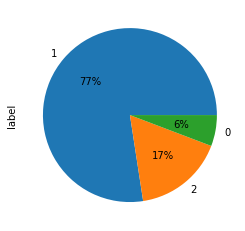

In [7]:
# inspect the classes' frequency
raw['label'].value_counts(normalize=True).plot.pie(autopct='%1.0f%%')
plt.show()

### Perform classification

In [ ]:
dflearn = pd.DataFrame()
dflearn['target'] = raw['label']
dflearn['text'] = raw['tweet']
dflearn.head()

,target,text
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
# split the sample in train + test
X = dflearn[['text']]
y = dflearn['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

### Custom transformer

In [ ]:
class CleanText( BaseEstimator, TransformerMixin ):
    
    def __init__( self):
        return
      
    def fit( self, X, y = None ):
        return self 
    
    def clean( self, x ):
        string = pd.Series(x.lower()).str.replace('[^\w\s]','',regex=True)[0]
        return string.strip()
    
    def transform( self, X, y = None ):
        return X["text"].apply(self.clean)

In [ ]:
# test method in the class
cl = CleanText()
cl.transform(X_train)

22893              why is this bitch throwing condoms lmao
18933    rt dsrtvet foxnews tjoy7 and i dont have any c...
18541    rt alicia_garcia3 thats why god made brownies ...
11578                      if thats yo hoe  thats my hoe 2
7699     am sorry i cant stand stand some black females...
                               ...                        
21575    the last atbat at yankee stadium thanks for ma...
5390     _bradleey lmfaoooo yooo i lost my elevator pas...
860      pornandroidiphoneipadsexxxx  anal  hardcore br...
15795    rt jennyjohnsonhi5 just when i thought justin ...
23654    bitches ain8217t shit and they ain8217t saying...
Name: text, Length: 12391, dtype: object

### Custom feature extraction
Adding extra features like the length of the reviews, punctuation elements, and some granular elements of punctuation like exclamation marks

In [ ]:
class CustomFeatures( BaseEstimator, TransformerMixin ):
    
    # Class Constructor 
    def __init__( self ):
        return
    
    # Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
        
    # Method that describes what we need this transformer to do i.e.
    # returning length and punctuations in the 'text' column in data frame
    def transform( self, X, y = None ):
        f           = pd.DataFrame()
        f['len']    = X['text'].str.len()
        f['punct']  = X['text'].str.findall(r'[^a-zA-Z\d\s:]').str.len()
        f['excl']  = X['text'].str.findall(r'!').str.len()
        return f[['len','punct','excl']]

In [ ]:
# testing the method transform of the custom features
obj = CustomFeatures()
obj.transform(X_train)

,len,punct,excl
22893,40,1,0
18933,146,9,1
18541,68,7,0
11578,36,5,0
7699,137,1,0
...,...,...,...
21575,117,10,0
5390,164,15,0
860,109,19,0
15795,146,6,0


### Pipeline

In [ ]:
pipe = Pipeline([("extract", FeatureUnion([("terms", Pipeline([('clean', CleanText()), 
                                                               ('tfidf', TfidfVectorizer())])),
                                           ("custom", CustomFeatures())]))])

In [ ]:
pipe_logistic = Pipeline([('pre_process', pipe),
                          ('classify', LogisticRegression(penalty='l2',max_iter=10000))])

In [ ]:
# Fit on training
pipe_logistic.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('pre_process',
                 Pipeline(memory=None,
                          steps=[('extract',
                                  FeatureUnion(n_jobs=None,
                                               transformer_list=[('terms',
                                                                  Pipeline(memory=None,
                                                                           steps=[('clean',
                                                                                   CleanText()),
                                                                                  ('tfidf',
                                                                                   TfidfVectorizer(analyzer='word',
                                                                                                   binary=False,
                                                                                                   decode_error='strict',
       

In [ ]:
# Evaluate on test
y_pred = pipe_logistic.predict(X_test)
y_true = y_test

In [ ]:
f1_score(y_true,y_pred,average='weighted')

0.8565957761278645

### Xgboost attempt

In [ ]:
pipe_xgb = Pipeline([('pre_process', pipe),
                     ('clf',  xgb.XGBClassifier(objective= 'multi:softprob'))])

In [ ]:
# Fit on training
pipe_xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('pre_process',
                 Pipeline(memory=None,
                          steps=[('extract',
                                  FeatureUnion(n_jobs=None,
                                               transformer_list=[('terms',
                                                                  Pipeline(memory=None,
                                                                           steps=[('clean',
                                                                                   CleanText()),
                                                                                  ('tfidf',
                                                                                   TfidfVectorizer(analyzer='word',
                                                                                                   binary=False,
                                                                                                   decode_error='strict',
       

In [ ]:
# Evaluate on test
y_pred = pipe_xgb.predict(X_test)
y_true = y_test

In [ ]:
f1_score(y_true,y_pred,average='weighted')

0.8391191896997796

### PCA attempt

In [ ]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [ ]:
from sklearn.decomposition import PCA
# pipe with feature selection
pipe_special = Pipeline([("extract", FeatureUnion([("terms", Pipeline([('clean', CleanText()), 
                                                               ('tfidf', TfidfVectorizer())])),
                                           ("custom", CustomFeatures())])),
                 ("dt", DenseTransformer()),
                 ("scale", StandardScaler()),
                 ('reduce_dim', PCA(n_components=500)),
                 ('classify', LogisticRegression(max_iter=10000))
                 ])


pipe_special.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('extract',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('terms',
                                                 Pipeline(memory=None,
                                                          steps=[('clean',
                                                                  CleanText()),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.float64'>,
                                                                                  encoding='utf-8',
                                   

In [ ]:
y_pred = pipe_special.predict(X_test)
y_true = y_test

In [ ]:
f1_score(y_true,y_pred,average='weighted')

0.7571870976046808

In [ ]:
accuracy_score(y_true,y_pred)

0.7966429954809554

### Preprocessing and feature extraction

In [8]:
!pip install text-preprocessing
!pip install tweet-preprocessor

     |████████████████████████████████| 2.7MB 27.0MB/s 
     |████████████████████████████████| 62.6MB 73kB/s 
     |████████████████████████████████| 327kB 44.5MB/s 
     |████████████████████████████████| 286kB 42.6MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85398 sha256=01fdac90348adb8afb58cd584f6fb342d6ccdf2e2ccb1677c8eb7a4d0d4eb08b
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [9]:
# normalise tags, URLS, emoji, and smiley
# the hashtags are left because they could incorporate hate speech to detect
import preprocessor as p
p.set_options(p.OPT.MENTION, p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)
raw['normalised'] = [p.tokenize(x) for x in raw['tweet']]

In [10]:
from text_preprocessing import preprocess_text
from text_preprocessing import to_lower, expand_contraction, remove_number, remove_punctuation, remove_whitespace, normalize_unicode, lemmatize_word

In [11]:
# Preprocess text using custom preprocess functions in the pipeline
def preprocess_txt(x):
  preprocess_functions = [to_lower, expand_contraction, remove_number, remove_punctuation,
                          remove_whitespace, normalize_unicode, lemmatize_word]
  preprocessed_text = preprocess_text(x, preprocess_functions)
  return preprocessed_text.replace("rt ", "").strip()

raw['cleaned'] = [preprocess_txt(x) for x in raw['normalised']]

### TF-IDF Feature Extraction

In [12]:
# split the sample in train + test
corpus = raw['cleaned']
y = raw['label']
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, y, test_size=0.5, random_state=42)

In [13]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit(corpus_train)
tfidf_train =  tfidf.transform(corpus_train)
tfidf_test =  tfidf.transform(corpus_test)

In [14]:
print(tfidf_train.shape)
print(tfidf_test.shape)

(12391, 13530)
(12392, 13530)


### Doc2vec

In [15]:
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [16]:
def token_label(corpus,labels):
  result = pd.DataFrame()
  result['tokens'] = [nltk.word_tokenize(x) for x in corpus]
  result['label'] = labels.tolist()
  return result

In [17]:
train_tagged = token_label(corpus_train,y_train).apply(
    lambda r: TaggedDocument(words=r['tokens'], tags=[r.label]), axis=1)
test_tagged = token_label(corpus_test,y_test).apply(
    lambda r: TaggedDocument(words=r['tokens'], tags=[r.label]), axis=1)

In [18]:
import multiprocessing

cores = multiprocessing.cpu_count()
from tqdm import tqdm
from sklearn import utils

In [19]:
model_dbow = Doc2Vec(vector_size=300, workers=cores, seed=123)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 12391/12391 [00:00<00:00, 1299030.72it/s]


In [21]:
%%time
for epoch in range(20):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 12391/12391 [00:00<00:00, 1981834.23it/s]


CPU times: user 30.6 s, sys: 3.44 s, total: 34.1 s
Wall time: 24.8 s


In [22]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [23]:
# return the features
y_train, doc2vec_train = vec_for_learning(model_dbow, train_tagged)
y_test, doc2vec_test = vec_for_learning(model_dbow, test_tagged)

### Attempt to merge the features

In [24]:
type(tfidf_train)

scipy.sparse.csr.csr_matrix

In [25]:
type(doc2vec_train)

tuple

In [26]:
tfidf_train.toarray().shape

(12391, 13530)

In [27]:
np.asarray(doc2vec_train).shape

(12391, 300)

In [28]:
merged_train = np.concatenate((tfidf_train.toarray(),np.asarray(doc2vec_train)),axis=1)

In [29]:
type(merged_train)

numpy.ndarray

In [30]:
### rescale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_train = scaler.fit_transform(merged_train)

In [31]:
scaled_train.shape

(12391, 13830)

In [32]:
# delete what's not needed anymore
del merged_train
del tfidf_train

Attempt to use PCA to reduce features

In [37]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random
svd = TruncatedSVD(n_components=500, random_state=42)
model = svd.fit(scaled_train)

In [38]:
reduced = model.transform(scaled_train)

In [42]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0,max_iter=1000).fit(reduced, y_train)
predicted = clf.predict(reduced)

In [49]:
from sklearn.metrics import accuracy_score
accuracy_score(predicted,y_train)

0.8907271406666128